In [ ]:
import pandas as pd

df = pd.read_csv("creditcard.csv")
print(df.shape, "\n")
df.head()

(284807, 31) 



,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Data Preparation

In [47]:
from sklearn.preprocessing import StandardScaler

# sampled_df = df.sample(n = 100000)
scaled_df = StandardScaler().fit_transform(df.drop("Class", axis = 1))
scaled_df.shape

(284807, 30)

## Train Reducer

In [49]:
import umap

reducer = umap.UMAP()
%time embedding = reducer.fit_transform(scaled_df)

CPU times: user 29min 29s, sys: 9min 29s, total: 38min 58s
Wall time: 5min 25s


In [42]:
df['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [50]:
embedding.shape

(284807, 2)

## Visualize Dataset

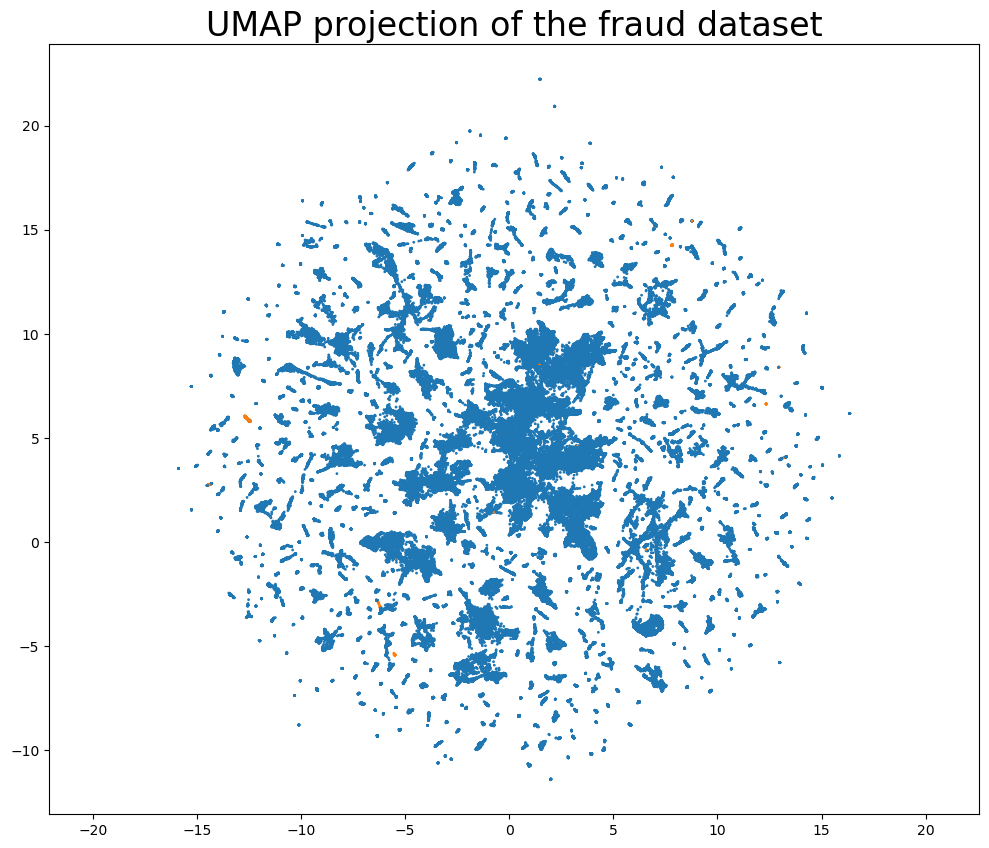

In [51]:
import matplotlib.pyplot as plt 
import seaborn as sns

def umap_scatter_plot(embedding, df_class_column):

    if embedding.ndim == 2 and embedding.shape[1] >= 2:
        
        plt.figure(figsize=(12, 10))
        colours = [sns.color_palette()[x] for x in df_class_column]
                
        plt.scatter(
            x = embedding[:, 0],
            y = embedding[:, 1],
            c = colours,
            s = 1
            )

        plt.gca().set_aspect('equal', 'datalim')
        plt.title('UMAP projection of the fraud dataset', fontsize = 24)
        plt.show()
        
        
    else: 
        print("Error: `embedding` should be a 2-dimensional array with at least 2 columns.")
        
        
umap_scatter_plot(embedding, df["Class"])

In [3]:
# UMAP(a = None,
#      angular_rp_forest = False,
#      b = None,
#      force_approximation_algorithm = False, 
#      init = 'spectral', 
#      learning_rate = 1.0,
#      local_connectivity = 1.0, 
#      low_memory = False, 
#      metric='euclidean',
#      metric_kwds=None, 
#      min_dist=0.1, 
#      n_components=2, 
#      n_epochs=None,
#      n_neighbors=15, 
#      negative_sample_rate=5, 
#      output_metric='euclidean',
#      output_metric_kwds=None, 
#      random_state=42, 
#      repulsion_strength=1.0,
#      set_op_mix_ratio=1.0, 
#      spread=1.0, 
#      target_metric='categorical',
#      target_metric_kwds=None, 
#      target_n_neighbors=-1, 
#      target_weight=0.5,
#      transform_queue_size=4.0, 
#      transform_seed=42, 
#      unique=False, 
#      verbose=False)

NameError: name 'UMAP' is not defined